# Assignment 7
## Comp 4448, Fall 2021
### David Kuralt
### Both datasets for this assignment can be found on https://vincentarelbundock.github.io/Rdatasets/articles/data.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

## Part 1, Channing House dataset
### Description of the variables:
#### A data frame with 457 observations on 5 variables
#### sex: a factor for the sex of each resident with levels Female Male
#### entry: the resident's age, in months, on entry to the center
#### exit: the resident's age, in months, upon death or upon the date the study ended on July 1, 1975
#### time: the length of time, in months, that the resident lived at Channing House before dying or the end of the study
#### cens: 1 if resident died, 0 if resident left Channing House, or if resident was still there as of the end of the study

In [2]:
chan_df = pd.read_csv("ChanningHouse.csv") 
# we drop the time column since time is explicitly a linear combination of entry and exit
chan_df.drop(["Unnamed: 0", "time"], axis=1, inplace=True)
chan_df.head()

,sex,entry,exit,cens
0,Male,782,909,1
1,Male,1020,1128,1
2,Male,856,969,1
3,Male,915,957,1
4,Male,863,983,1


In [3]:
# missing variables?
chan_df.isna().any()

sex      False
entry    False
exit     False
cens     False
dtype: bool

In [4]:
# checking values for sex
chan_df["sex"].unique()

array(['Male', 'Female'], dtype=object)

In [5]:
# checking values for cens
chan_df["cens"].unique()

array([1, 0])

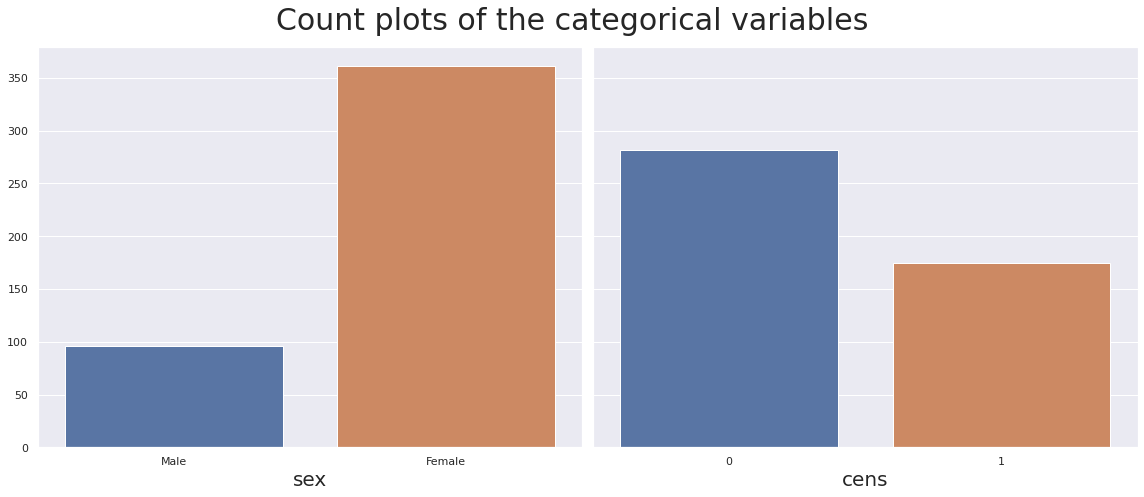

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16,7), sharey=True)
sns.countplot(x="sex", data=chan_df, ax=ax[0])
sns.countplot(x="cens", data=chan_df, ax=ax[1])
ax[0].set_ylabel("")
ax[0].set_xlabel("sex", size=20)
ax[1].set_ylabel("")
ax[1].set_xlabel("cens", size=20)
fig.suptitle("Count plots of the categorical variables", size=30)
plt.tight_layout()

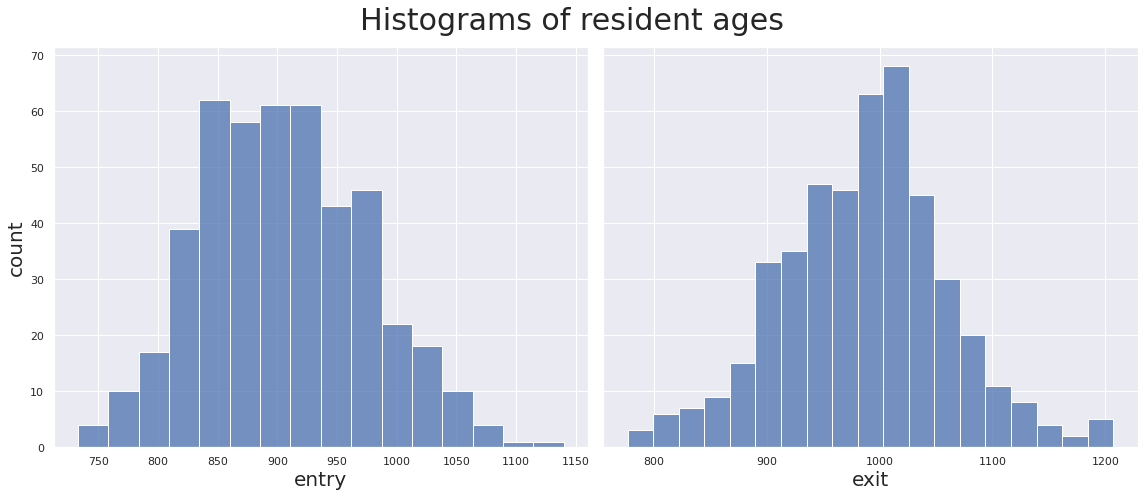

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,7), sharey=True)
sns.histplot(x="entry", data=chan_df, ax=ax[0])
sns.histplot(x="exit", data=chan_df, ax=ax[1])
ax[0].set_ylabel("count", size=20)
ax[0].set_xlabel("entry", size=20)
ax[1].set_xlabel("exit", size=20)
fig.suptitle("Histograms of resident ages", size=30)
plt.tight_layout()

### Preparing for PCA

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# scaling the numerical variables
chan_df[["entry", "exit"]] = scaler.fit_transform(chan_df[["entry", "exit"]])

# turning chan_df back into a dataframe
chan_df = pd.DataFrame(chan_df, columns=["sex", "entry", "exit", "cens"])

# encoding sex
chan_df = chan_df.replace({"Male":0, "Female":1})
chan_df.head()

,sex,entry,exit,cens
0,0,-1.776485,-1.048436,1
1,0,1.649786,1.914450,1
2,0,-0.711174,-0.236686,1
3,0,0.138196,-0.399036,1
4,0,-0.610401,-0.047278,1


### Doing the PCA
Honestly, I could have gotten over 93% of the explained variance in the data had I chosen the first three components, but I struggle mightily with 3D data visualization, so I kept the dimensions down to 2.

In [9]:
from sklearn.decomposition import PCA

decomp = PCA(n_components=2, svd_solver="full")
X2D = decomp.fit_transform(chan_df)

In [10]:
# the component vectors
decomp.components_

array([[-0.02373694,  0.70672093,  0.70274925,  0.07826599],
       [-0.19388591,  0.43213572, -0.52026992,  0.7106238 ]])

In [11]:
# cumulative sum of the explained variance ratios
np.cumsum(decomp.explained_variance_ratio_)

array([0.74476969, 0.86140257])

### Agglomerative clustering and KMeans
Using 2, 3, or 4 clusters would work well according to both the dendrogram and the KMeans visualizations. Beyond 4, things get kind of messy. In the KMeans visualizations, we see that the clusters are differentiated mainly along the principal axis.

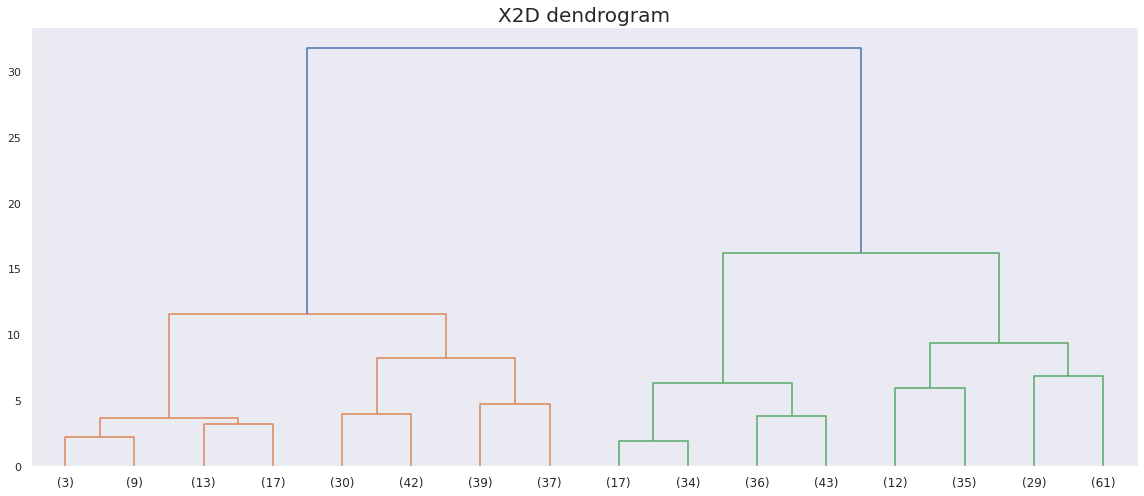

In [12]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

cluster = AgglomerativeClustering(n_clusters=None,
                                  compute_full_tree=True, 
                                  distance_threshold=0)

cluster.fit_predict(X2D)

# I copied this function directly from the documentation
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize=(16,7))
plot_dendrogram(cluster, truncate_mode="level", p=3)
ax.grid(b=None)
ax.set_title("X2D dendrogram", size=20)
plt.tight_layout()

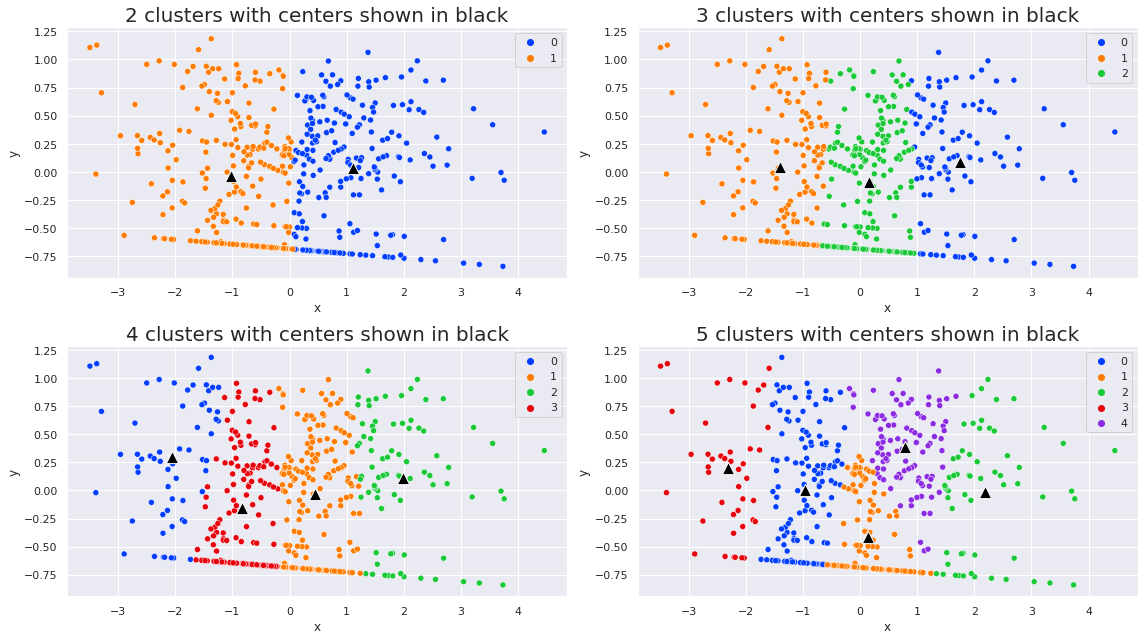

In [13]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 2, figsize=(16,9))

for i in range(2,6):
    k_cluster = KMeans(n_clusters=i, random_state=45)
    k_cluster.fit_predict(X2D)
    center = k_cluster.cluster_centers_
    df = pd.DataFrame(X2D, columns=["x", "y"])
    df["labels"] = k_cluster.labels_
    sns.scatterplot(x="x", y="y", hue="labels", data=df, palette="bright", ax=ax[(i-2)//2,(1+(-1)**(i+1))//2])
    sns.scatterplot(x=center[:,0], y=center[:,1], color="black",
                    marker="^", s=150, ax=ax[(i-2)//2,(1+(-1)**(i+1))//2])
    ax[(i-2)//2,(1+(-1)**(i+1))//2].set_title(str(i) + " clusters with centers shown in black", size=20)

plt.tight_layout()

### The verdict
I'm going ahead with two clusters because I like the simplicity of a binary classifier.

In [14]:
k_cluster = KMeans(n_clusters=2, random_state=45)
k_cluster.fit_predict(X2D)

chan_df["labels"] = k_cluster.labels_
chan_df.head()

,sex,entry,exit,cens,labels
0,0,-1.776485,-1.048436,1,1
1,0,1.649786,1.914450,1,0
2,0,-0.711174,-0.236686,1,1
3,0,0.138196,-0.399036,1,1
4,0,-0.610401,-0.047278,1,1


In [15]:
# getting the dataframe ready for logistic regression
from sklearn.model_selection import train_test_split

X = chan_df.drop("labels", axis=1)
y = chan_df["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=75)

### Logistic regression and tuning

In [16]:
# looping over several possible values of C
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

c_list = [0.2, 0.4, 0.6, 0.8, 1.0]
err_list = []

for cutoff in c_list:
    test_model = LogisticRegression(C=cutoff)
    test_model.fit(X_train, y_train)
    y_pred = test_model.predict(X_train)
    err_list.append(1 - accuracy_score(y_train, y_pred))

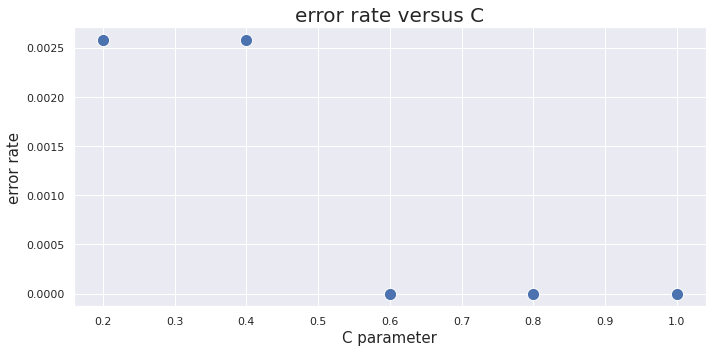

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x=c_list, y=err_list, s=150)
ax.set_title("error rate versus C", size=20)
ax.set_ylabel("error rate", size=15)
ax.set_xlabel("C parameter", size=15)
plt.tight_layout()

### Our choice of C and final results

In [18]:
final_model = LogisticRegression() # we choose the default C=1.0
final_model.fit(X_train, y_train)
y_test_pred = final_model.predict(X_test)
print("Accuracy score on the test set is " + str(accuracy_score(y_test, y_test_pred)))

Accuracy score on the test set is 0.9855072463768116


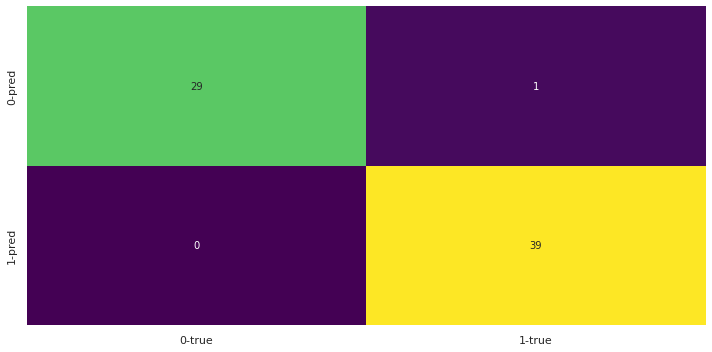

In [19]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap="viridis", cbar=False)
ax.set_yticklabels(["0-pred", "1-pred"])
ax.set_xticklabels(["0-true", "1-true"])
plt.tight_layout()

### Interpreting the results
Logistic regression on our choice of clustering produces a model that returns 98.6% accuracy on the test set with only one misclassification of a 1 datapoint as a 0. Our principal vector is [-0.02373694,  0.70672093,  0.70274925,  0.07826599]. I noted earlier that the differentiation of the clusters is mainly along the principal component. The relatively small coefficient for the sex variable shows that this variable plays a relatively weak role in explaining the total variance of the dataset, while the remaining three, which together describe a resident's length of stay at Channing House and whether or not the resident died, explain most of the variance. Cluster 0, shown in blue, shows the residents who spent the most time at Channing House. Cluster 1, in orange, shows residents who spent less time there. 

## Part 2, prostate dataset
### Description of the variables
#### A data frame with 14294 observations on the following 5 variables.
#### grade: a factor with levels mode (moderately differentiated) and poor (poorly differentiated)
#### stage: a factor with levels T1ab (Stage T1, clinically diagnoseed), T1c (Stage T1, diagnosed via a PSA test), and T2 (Stage T2)
#### ageGroup: a factor with levels 66-69 70-74 75-79 80+
#### survTime: time from diagnosis to death or last date known alive
#### status: a censoring variable, 0, (censored), 1 (death from prostate cancer), and 2 (death from other causes)

In [20]:
# status is our target variable. 
prostate = pd.read_csv("prostateSurvival.csv")
prostate.drop("Unnamed: 0", axis=1, inplace=True)
prostate.head()

,grade,stage,ageGroup,survTime,status
0,mode,T1c,80+,18,0
1,mode,T1ab,75-79,23,0
2,poor,T1c,75-79,37,0
3,mode,T2,70-74,27,0
4,mode,T1c,70-74,42,0


### Becoming acquainted with the data

In [21]:
prostate.isna().any()

grade       False
stage       False
ageGroup    False
survTime    False
status      False
dtype: bool

In [22]:
prostate.dtypes

grade       object
stage       object
ageGroup    object
survTime     int64
status       int64
dtype: object

In [23]:
prostate["grade"].unique()

array(['mode', 'poor'], dtype=object)

In [24]:
prostate["stage"].unique()

array(['T1c', 'T1ab', 'T2'], dtype=object)

In [25]:
prostate["ageGroup"].unique()

array(['80+', '75-79', '70-74', '66-69'], dtype=object)

In [26]:
prostate["status"].unique()

array([0, 2, 1])

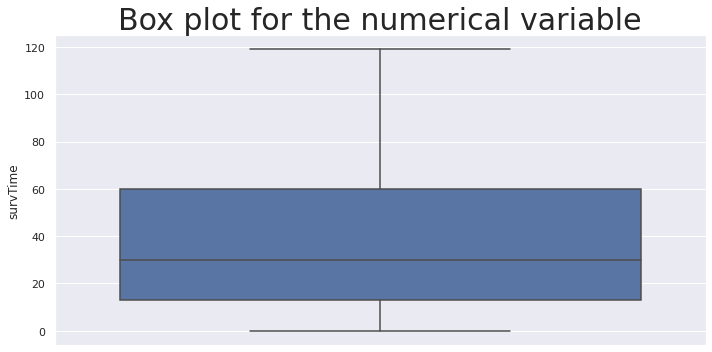

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(y="survTime", data=prostate)
ax.set_title("Box plot for the numerical variable", size=30)
plt.tight_layout()

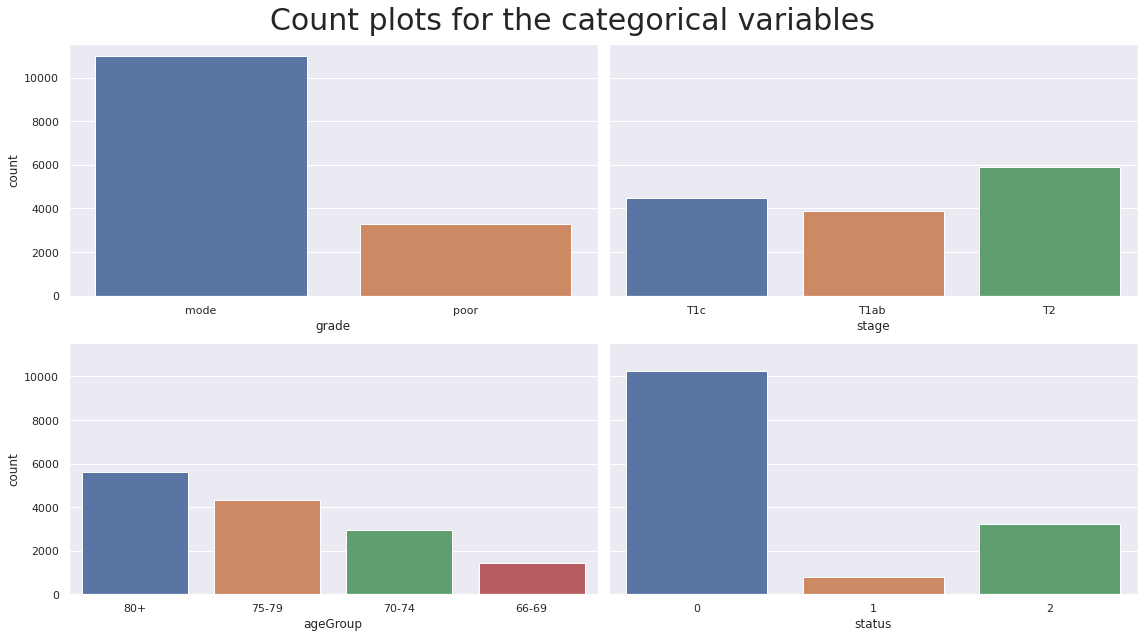

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(16,9), sharey=True)
fig.suptitle("Count plots for the categorical variables", size=30)
sns.countplot(x="grade", data=prostate, ax=ax[0,0])
sns.countplot(x="stage", data=prostate, ax=ax[0,1])
sns.countplot(x="ageGroup", data=prostate, ax=ax[1,0])
sns.countplot(x="status", data=prostate, ax=ax[1,1])
ax[0,1].set_ylabel("")
ax[1,1].set_ylabel("")
plt.tight_layout()

### Preparing for logistic regression

In [29]:
prostate = prostate.replace({"mode":0, "poor":1})
prostate = prostate.replace({"66-69":0, "70-74":1, "75-79":2, "80+":3})
prostate = prostate.replace({"T1ab":0, "T1c":1, "T2":2})
prostate.head()

,grade,stage,ageGroup,survTime,status
0,0,1,3,18,0
1,0,0,2,23,0
2,1,1,2,37,0
3,0,2,1,27,0
4,0,1,1,42,0


In [30]:
# splitting the data. note that we carve out 90% for the training data due to the severe imbalance of 
# 1 and 2 status compared to 0 status
X = prostate.drop("status", axis=1)
y= prostate["status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=175)

### Logistic regression using *statsmodels*

In [31]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit

In [32]:
# because this case is not binary classification, we use the multinomial logit model
log_mod = sm.MNLogit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.784139
         Iterations 7


In [33]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 status   No. Observations:                12864
Model:                        MNLogit   Df Residuals:                    12856
Method:                           MLE   Df Model:                            6
Date:                Wed, 17 Nov 2021   Pseudo R-squ.:                -0.06542
Time:                        14:59:13   Log-Likelihood:                -10087.
converged:                       True   LL-Null:                       -9467.8
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
  status=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
grade          1.0923      0.074     14.772      0.000       0.947       1.237
stage         -0.7027      0.038    -18.571      0.000      -0.777      -0.629
ageGroup      -0.5407      0.025    -21.724      0.000      -0.589      -0.492
survTime      -0.0202      0.001    -17.456      0.000      -0.022      -0.018
------------------------------------------------------------------------------
  status=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
grade          0.1660      0.051      3.253      0.001       0.066       0.266
stage         -0.4549      0.023    -19.737      0.000      -0.500      -0.410
ageGroup      -0.1229      0.015     -8.266      0.000      -0.152      -0.094
survTime      -0.0059      0.001     -9.947      0.000      -0.007      -0.005
==============================================================================
"""

In [34]:
# exponentiating the coefficients so we can interpret them
# column 0 corresponds to the exponentiated coefficients from status=1
# column 1 corresponts to the exponentiated coefficients from status=2
np.exp(log_mod.params)

,0,1
grade,2.981089,1.180558
stage,0.495235,0.634543
ageGroup,0.582343,0.884381
survTime,0.980041,0.994130


## Comments on the model results
#### The small p-values suggest that there is a significant relationship between each of the variables and the outcome status, both for outcome 1 and outcome 2
### Model coefficients: holding all other coefficients constant...
#### An increase by 1 *grade* level increases the odds of dying from prostate cancer by 2.98 (status=1) and the odds of dying from some other cause (status=2) by 1.18.
#### An increase by 1 *stage* level increases the odds of dying from prostate cancer by 0.495 and dying from some other cause by 0.635.
#### An increase by 1 *ageGroup* level increases the odds of dying from prostate cancner by 0.582 and dying from some other cause by 0.884.
#### An increase of 1 month in *survTime* increases the odds of dying from prostate cancer by 0.980 and dying from some other cause by 0.994.
### Now we move on to assess the model's accuracy

In [35]:
# the performance of the model on the training set
y_train_pred = log_mod.predict(X_train)
y_train_pred = y_train_pred.idxmax(axis=1)
accuracy_score(y_train, y_train_pred)

0.7129197761194029

In [36]:
# the performance of the model on the test set
y_test_pred = log_mod.predict(X_test)
y_test_pred = y_test_pred.idxmax(axis=1)
accuracy_score(y_test, y_test_pred)

0.713986013986014

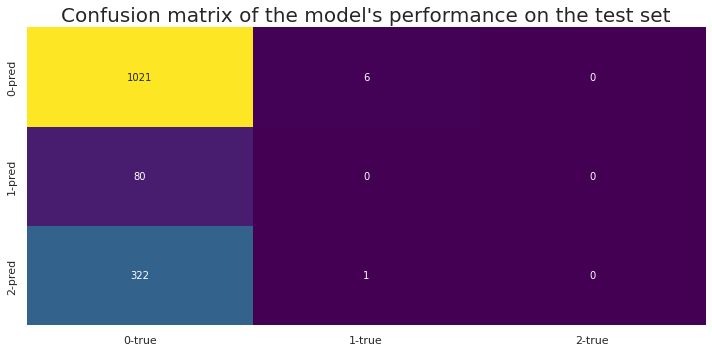

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_test_pred),
           annot=True,
            fmt="g",
           cmap="viridis",
           cbar=False)
ax.set_yticklabels(["0-pred", "1-pred", "2-pred"])
ax.set_xticklabels(["0-true", "1-true", "2-true"])
ax.set_title("Confusion matrix of the model's performance on the test set", size=20)
plt.tight_layout()

### Because there are so many more 0 status instances in our data than there are of 1 or 2 status instances, our model does not accurately predict any of the 1 or 2 instances. So even though the model does not overfit the data, it is not a very effective model.